In [23]:
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Load Dataset

In [24]:
# Define transformation for training (with augmentation) and testing (no augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

Preprocessing Data

In [25]:
def preprocessing(dataset):
    data = dataset.data.reshape((-1, 28*28)).float().numpy()
    # Normalization of pixel values
    data /= 255.0
    
    # One-hot encoding for labels
    labels = dataset.targets.numpy()
    classes = len(np.unique(labels)) 
    labels = np.eye(classes)[labels - 1]
    
    return data, labels


Base Layer

In [26]:
class BaseLayer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        raise NotImplementedError()
    
    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError()
    
def xavier_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2.0 / (input_size + output_size))


Optimization


In [27]:
class AdamOptimizer:
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-6):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.mb = None
        self.vw = None
        self.vb = None
        self.t = 0
        
    def update(self, weights, biases, weights_gradient, biases_gradient, learning_rate):
        self.t += 1
        # print(self.t)
        if self.mw is None:
            self.mw = np.zeros_like(weights)
            self.mb = np.zeros_like(biases)
            self.vw = np.zeros_like(weights)
            self.vb = np.zeros_like(biases)
        self.mw = self.beta1 * self.mw + (1 - self.beta1) * weights_gradient
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * biases_gradient
        self.vw = self.beta2 * self.vw + (1 - self.beta2) * np.power(weights_gradient, 2)
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * np.power(biases_gradient, 2)
        mw_hat = self.mw / (1 - np.power(self.beta1, self.t))
        mb_hat = self.mb / (1 - np.power(self.beta1, self.t))
        vw_hat = self.vw / (1 - np.power(self.beta2, self.t))
        vb_hat = self.vb / (1 - np.power(self.beta2, self.t))
        weights -= learning_rate * mw_hat / (np.sqrt(vw_hat) + self.epsilon)
        biases -= learning_rate * mb_hat / (np.sqrt(vb_hat) + self.epsilon)
        

Dense Layer

In [28]:
class DenseLayer(BaseLayer):
    def __init__(self, input_size, output_size, initializer=xavier_initialization, optimizer=AdamOptimizer):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = initializer(self.input_size, self.output_size)
        self.biases = initializer(1, self.output_size)
        self.optimizer = optimizer()
        
    def forward(self, input):
        self.input = input
        # y = xW+b
        self.output = np.dot(self.input, self.weights) + self.biases
        return self.output 

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.input.T, output_gradient)
        biases_gradient = np.sum(output_gradient, axis=0)
        self.optimizer.update(self.weights, self.biases, weights_gradient, biases_gradient, learning_rate)
        
        return input_gradient


Batch Normalization

In [29]:
class BatchNormalizationLayer(BaseLayer):
    def __init__(self, input_size, momentum=0.9, epsilon=1e-8):
        # Parameters
        self.gamma = np.ones((1, input_size))  # Scale parameter (initialized to 1)
        self.beta = np.zeros((1, input_size))  # Shift parameter (initialized to 0)
        self.momentum = momentum  # Momentum for running mean and variance
        self.epsilon = epsilon  # Small constant to avoid division by zero

        # Moving averages of mean and variance (used during inference)
        self.running_mean = np.zeros((1, input_size))
        self.running_variance = np.zeros((1, input_size))
    
    def forward(self, input, training=True):
        self.input = input
        
        if training:
            # Compute mean and variance for the current batch
            self.batch_mean = np.mean(self.input, axis=0, keepdims=True)
            self.batch_variance = np.var(self.input, axis=0, keepdims=True)

            # Normalize the batch
            self.x_hat = (self.input - self.batch_mean) / np.sqrt(self.batch_variance + self.epsilon)

            # Update running mean and variance (exponentially weighted average)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_variance = self.momentum * self.running_variance + (1 - self.momentum) * self.batch_variance
        else:
            # Use the running mean and variance during inference
            self.x_hat = (self.input - self.running_mean) / np.sqrt(self.running_variance + self.epsilon)

        # Scale and shift the normalized data
        self.output = self.gamma * self.x_hat + self.beta
        
        return self.output

    def backward(self, output_gradient, learning_rate):
        #inputs in the batch
        m = self.input.shape[0]

        # Gradients w.r.t. gamma and beta
        gamma_gradient = np.sum(output_gradient * self.x_hat, axis=0, keepdims=True)
        beta_gradient = np.sum(output_gradient, axis=0, keepdims=True)

        # Gradient of the loss w.r.t. the normalized input (x_hat)
        dx_hat = output_gradient * self.gamma

        # Gradients w.r.t. the batch mean and variance
        dvariance = np.sum(dx_hat * (self.input - self.batch_mean) * -0.5 * np.power(self.batch_variance + self.epsilon, -1.5), axis=0, keepdims=True)
        dmean = np.sum(dx_hat * -1 / np.sqrt(self.batch_variance + self.epsilon), axis=0, keepdims=True) + dvariance * np.mean(-2 * (self.input - self.batch_mean), axis=0, keepdims=True)

        # Gradient of the input
        input_gradient = dx_hat / np.sqrt(self.batch_variance + self.epsilon) + dvariance * 2 * (self.input - self.batch_mean) / m + dmean / m

        # Update gamma and beta
        self.gamma -= learning_rate * gamma_gradient
        self.beta -= learning_rate * beta_gradient

        return input_gradient


normalizing the inputs to a layer so that they have zero mean and unit variance during training.

In [30]:
class ActivationFunction(BaseLayer):
    def __init__(self, activation, derivative):
        self.activation = activation
        self.derivative = derivative
        
    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = np.multiply(output_gradient, self.derivative(self.input))
        return input_gradient
    

ReLU

In [31]:
class ReLU(ActivationFunction):
    def __init__(self):
        super().__init__(self.relu, self.relu_derivative)
        
    def relu(self, x):
        return np.maximum(0, x) # ReLU = max(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0) # Derivative of ReLU = 1 if x > 0, 0 otherwise

DropOut

In [32]:
class DropoutLayer:    
    def __init__(self, dropout_prob):
        self.dropout = dropout_prob
        self.mask = None
        
    def forward(self, input):
        self.input = input
        if self.dropout == 0:
            self.output = self.input
            return self.output
        elif self.dropout == 1:
            self.output = np.zeros(self.input.shape)
            return self.output
        self.mask = (np.random.rand(*self.input.shape) > self.dropout).astype(float)
        self.output = np.multiply(self.input, self.mask) / (1 - self.dropout)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = np.multiply(output_gradient, self.mask) / (1 - self.dropout)
        return input_gradient

Softmax

In [33]:
def softmax(x):
    expo = np.exp(x - np.max(x, axis=1, keepdims=True))
    expsum = np.sum(expo, axis=1, keepdims=True)
    return expo / expsum
class Softmax(ActivationFunction):
    def __init__(self): 
        super().__init__(softmax, self.return_ones)
        
    def return_ones(self, x): # Derivative of softmax is 1
        return np.ones(x.shape)

In [34]:
class CrossEntropyLoss:
    def error(self, y_true, y_pred):
        assert y_true.shape == y_pred.shape, "Shape mismatch between y_true and y_pred"
        

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(np.multiply(y_true, np.log(y_pred)))
    
    def error_derivative(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return y_pred - y_true

Feed Forward Neural Network

In [ ]:
class FNN:
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, input):
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = output_gradient
        for layer in reversed(self.layers):
            input_gradient = layer.backward(input_gradient, learning_rate)
        return input_gradient
    
    

    def train(self, Loss, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        self.loss = Loss
        epoch_loss = []
        epoch_val_loss = []
        epoch_train_acc = []
        epoch_val_acc = []
        epoch_val_f1 = []

        for epoch in tqdm(range(epochs)):
            train_loss = 0
            train_correct = 0
            val_correct = 0
        
            # Training phase
            for j in range(0, len(X_train), batch_size):
                X_batch = X_train[j:j+batch_size]
                y_logits = y_train[j:j+batch_size]
                y_prediction = self.forward(X_batch)
            
                train_loss += self.loss.error(y_logits, y_prediction)
                y_batch_size = y_logits.shape[0]
            
                # If last layer is Softmax, compute the gradient for backward propagation
                if isinstance(self.layers[-1], Softmax):
                    output_gradient = (y_prediction - y_logits) / y_batch_size
                output_gradient = self.backward(output_gradient, learning_rate)
            
                # Calculate training accuracy for this batch
                predicted_classes = np.argmax(y_prediction, axis=1)
                true_classes = np.argmax(y_logits, axis=1)
                train_correct += np.sum(predicted_classes == true_classes)
        
            # Average training loss over all batches
            avg_train_loss = train_loss / (len(X_train) / batch_size)
            epoch_loss.append(avg_train_loss)

            # Calculate training accuracy for the epoch
            train_accuracy = 100 * train_correct / len(X_train)
            epoch_train_acc.append(train_accuracy)

            # Validation phase
            val_loss = 0
            y_val_pred = []
            y_val_true = []
        
            for k in range(0, len(X_val), batch_size):
                X_val_batch = X_val[k:k+batch_size]
                y_val_logits = y_val[k:k+batch_size]
                y_val_pred_batch = self.forward(X_val_batch)
            
                val_loss += self.loss.error(y_val_logits, y_val_pred_batch)
                predicted_classes = np.argmax(y_val_pred_batch, axis=1)
                true_classes = np.argmax(y_val_logits, axis=1)
                val_correct += np.sum(predicted_classes == true_classes)
            
                # Collect predictions and ground truths for F1 score calculation
                y_val_pred.extend(predicted_classes)
                y_val_true.extend(true_classes)
        
            # Average validation loss
            avg_val_loss = val_loss / (len(X_val) / batch_size)
            epoch_val_loss.append(avg_val_loss)

            # Validation accuracy
            val_accuracy = 100 * val_correct / len(X_val)
            epoch_val_acc.append(val_accuracy)

            # Calculate macro-F1 score for validation data
            val_f1_score = f1_score(y_val_true, y_val_pred, average='macro')
            epoch_val_f1.append(val_f1_score)

            print(f"Epoch {epoch+1}/{epochs}")
            
        return epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc, epoch_val_f1

    
    def predict(self, X):
        pred = FNN(self.layers)
        pred.layers = [layer for layer in self.layers if not isinstance(layer, DropoutLayer)]
        y_pred = pred.forward(X)
        return y_pred
    
    def get_weights(self):
        weights_dict = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights') and hasattr(layer, 'biases'):
                weights_dict[f'layer_{i}_weights'] = layer.weights
                weights_dict[f'layer_{i}_biases'] = layer.biases
        return weights_dict
    



Accuracy

In [36]:
import numpy as np

def calculate_metrics(model, X_test, y_test):
    # Predict classes
    y_pred = model.predict(X_test)
    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Initialize counters for the overall metrics
    tp = np.sum((predicted_classes == true_classes) & (true_classes == 1))  # True positives for positive class
    fp = np.sum((predicted_classes == 1) & (true_classes == 0))  # False positives for positive class
    fn = np.sum((predicted_classes == 0) & (true_classes == 1))  # False negatives for positive class
    tn = np.sum((predicted_classes == 0) & (true_classes == 0))  # True negatives for positive class

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes) * 100
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    #####
    print(f"Test Accuracy: {accuracy}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print(f"Specificity: {specificity}")



In [37]:
def create_models():
    return [
        FNN([
            DenseLayer(784, 512),
            BatchNormalizationLayer(512),
            ReLU(),
            DropoutLayer(0.5),
            DenseLayer(512, 128),
            ReLU(),
            DropoutLayer(0.25),
            DenseLayer(128, 64),
            ReLU(),
            DenseLayer(64, 10),
            Softmax()
        ]),
        FNN([
            DenseLayer(784, 256),
            BatchNormalizationLayer(256),
            ReLU(),
            DropoutLayer(0.4),
            DenseLayer(256, 128),
            ReLU(),
            DropoutLayer(0.3),
            DenseLayer(128, 32),
            ReLU(),
            DenseLayer(32, 10),
            Softmax()
        ]),
        FNN([
            DenseLayer(784, 1024),
            BatchNormalizationLayer(1024),
            ReLU(),
            DropoutLayer(0.6),
            DenseLayer(1024, 256),
            ReLU(),
            DropoutLayer(0.35),
            DenseLayer(256, 64),
            ReLU(),
            DenseLayer(64, 10),
            Softmax()
        ])
    ]

models = create_models()
best_f1_score = 0
best_model = None
best_lr = None
best_model_idx = -1


# Train
train_data, train_labels = preprocessing(train_dataset)
test_data, test_labels = preprocessing(test_dataset)
#learning rates
learning_rates = [0.005, 0.004, 0.003, 0.001]
for i, model in enumerate(models):
    print(f"Training Model {i + 1}")
    for j in range(len(learning_rates)):
        print(f"Training with learning rate: {learning_rates[j]}")
        epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc, epoch_val_f1 = model.train(CrossEntropyLoss(), train_data, train_labels,  test_data, test_labels, 10,learning_rates[j], 256)
        current_f1_score = epoch_val_f1[-1]
        
        # Check best F1 score
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_model = model
            best_lr = j
            best_model_idx = i + 1  
        calculate_metrics(model,test_data,test_labels)
    


Training Model 1
Training with learning rate: 0.005


 10%|█         | 1/10 [00:12<01:52, 12.49s/it]

Epoch 1/10


 20%|██        | 2/10 [00:25<01:41, 12.70s/it]

Epoch 2/10


 30%|███       | 3/10 [00:38<01:29, 12.78s/it]

Epoch 3/10


 40%|████      | 4/10 [00:50<01:15, 12.55s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:01<01:00, 12.05s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:12<00:47, 11.80s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:23<00:34, 11.46s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:34<00:22, 11.20s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:45<00:11, 11.08s/it]

Epoch 9/10


100%|██████████| 10/10 [01:55<00:00, 11.57s/it]

Epoch 10/10


Test Accuracy: 87.42%
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
Training with learning rate: 0.004


 10%|█         | 1/10 [00:10<01:36, 10.68s/it]

Epoch 1/10


 20%|██        | 2/10 [00:21<01:25, 10.71s/it]

Epoch 2/10


 30%|███       | 3/10 [00:32<01:14, 10.69s/it]

Epoch 3/10


 40%|████      | 4/10 [00:42<01:04, 10.73s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:53<00:53, 10.77s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:05<00:43, 10.99s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:17<00:33, 11.32s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:28<00:22, 11.33s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:40<00:11, 11.43s/it]

Epoch 9/10


100%|██████████| 10/10 [01:51<00:00, 11.11s/it]

Epoch 10/10


Test Accuracy: 88.75%
Precision: 0.9987293519695044
Recall: 1.0
F1 Score: 0.9993642720915448
Specificity: 0.9989701338825953
Training with learning rate: 0.003


 10%|█         | 1/10 [00:10<01:38, 10.89s/it]

Epoch 1/10


 20%|██        | 2/10 [00:21<01:27, 10.89s/it]

Epoch 2/10


 30%|███       | 3/10 [00:32<01:16, 10.87s/it]

Epoch 3/10


 40%|████      | 4/10 [00:43<01:05, 10.87s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:55<00:55, 11.18s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:06<00:45, 11.34s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:17<00:33, 11.20s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:28<00:22, 11.12s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:39<00:11, 11.09s/it]

Epoch 9/10


100%|██████████| 10/10 [01:50<00:00, 11.06s/it]

Epoch 10/10


Test Accuracy: 89.62%
Precision: 0.9987593052109182
Recall: 1.0
F1 Score: 0.9993792675356922
Specificity: 0.9989754098360656
Training with learning rate: 0.001


 10%|█         | 1/10 [00:11<01:39, 11.04s/it]

Epoch 1/10


 20%|██        | 2/10 [00:21<01:27, 10.96s/it]

Epoch 2/10


 30%|███       | 3/10 [00:32<01:16, 10.94s/it]

Epoch 3/10


 40%|████      | 4/10 [00:44<01:06, 11.04s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:54<00:54, 10.98s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:05<00:43, 10.98s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:16<00:32, 10.99s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:28<00:22, 11.19s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:38<00:10, 10.84s/it]

Epoch 9/10


100%|██████████| 10/10 [01:50<00:00, 11.04s/it]

Epoch 10/10


Test Accuracy: 90.09%
Precision: 0.9975903614457832
Recall: 1.0
F1 Score: 0.9987937273823884
Specificity: 0.9979550102249489
Training Model 2
Training with learning rate: 0.005


 10%|█         | 1/10 [00:05<00:53,  5.95s/it]

Epoch 1/10


 20%|██        | 2/10 [00:11<00:47,  5.95s/it]

Epoch 2/10


 30%|███       | 3/10 [00:17<00:40,  5.73s/it]

Epoch 3/10


 40%|████      | 4/10 [00:22<00:33,  5.51s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:29<00:29,  5.91s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:36<00:25,  6.47s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:43<00:19,  6.54s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:49<00:12,  6.39s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:55<00:06,  6.31s/it]

Epoch 9/10


100%|██████████| 10/10 [01:01<00:00,  6.11s/it]

Epoch 10/10


Test Accuracy: 88.03999999999999%
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
Training with learning rate: 0.004


 10%|█         | 1/10 [00:05<00:52,  5.88s/it]

Epoch 1/10


 20%|██        | 2/10 [00:11<00:44,  5.57s/it]

Epoch 2/10


 30%|███       | 3/10 [00:16<00:39,  5.62s/it]

Epoch 3/10


 40%|████      | 4/10 [00:22<00:34,  5.76s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:28<00:28,  5.68s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:34<00:23,  5.79s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:39<00:16,  5.66s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:45<00:11,  5.64s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:51<00:05,  5.82s/it]

Epoch 9/10


100%|██████████| 10/10 [00:57<00:00,  5.71s/it]

Epoch 10/10


Test Accuracy: 88.36%
Precision: 0.9986702127659575
Recall: 0.99734395750332
F1 Score: 0.9980066445182724
Specificity: 0.9989648033126294
Training with learning rate: 0.003


 10%|█         | 1/10 [00:05<00:50,  5.65s/it]

Epoch 1/10


 20%|██        | 2/10 [00:11<00:46,  5.84s/it]

Epoch 2/10


 30%|███       | 3/10 [00:17<00:40,  5.81s/it]

Epoch 3/10


 40%|████      | 4/10 [00:23<00:35,  5.93s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:29<00:29,  5.90s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:35<00:23,  5.87s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:41<00:17,  5.92s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:47<00:11,  5.98s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:53<00:05,  5.96s/it]

Epoch 9/10


100%|██████████| 10/10 [00:59<00:00,  5.92s/it]

Epoch 10/10


Test Accuracy: 88.89%
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
Training with learning rate: 0.001


 10%|█         | 1/10 [00:05<00:48,  5.43s/it]

Epoch 1/10


 20%|██        | 2/10 [00:10<00:44,  5.51s/it]

Epoch 2/10


 30%|███       | 3/10 [00:17<00:40,  5.75s/it]

Epoch 3/10


 40%|████      | 4/10 [00:22<00:34,  5.70s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:28<00:28,  5.70s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:34<00:23,  5.89s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:40<00:17,  5.78s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:45<00:11,  5.75s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:51<00:05,  5.77s/it]

Epoch 9/10


100%|██████████| 10/10 [00:57<00:00,  5.71s/it]

Epoch 10/10


Test Accuracy: 89.83%
Precision: 0.9987849331713244
Recall: 0.9987849331713244
F1 Score: 0.9987849331713244
Specificity: 0.9989785495403473
Training Model 3
Training with learning rate: 0.005


 10%|█         | 1/10 [00:26<04:00, 26.74s/it]

Epoch 1/10


 20%|██        | 2/10 [00:57<03:54, 29.31s/it]

Epoch 2/10


 30%|███       | 3/10 [01:25<03:20, 28.65s/it]

Epoch 3/10


 40%|████      | 4/10 [01:57<03:00, 30.00s/it]

Epoch 4/10


 50%|█████     | 5/10 [02:39<02:50, 34.17s/it]

Epoch 5/10


 60%|██████    | 6/10 [03:19<02:25, 36.34s/it]

Epoch 6/10


 70%|███████   | 7/10 [04:03<01:56, 38.68s/it]

Epoch 7/10


 80%|████████  | 8/10 [04:42<01:17, 38.83s/it]

Epoch 8/10


 90%|█████████ | 9/10 [05:16<00:37, 37.17s/it]

Epoch 9/10


100%|██████████| 10/10 [05:38<00:00, 33.86s/it]

Epoch 10/10


Test Accuracy: 87.41%
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
Training with learning rate: 0.004


 10%|█         | 1/10 [00:22<03:21, 22.40s/it]

Epoch 1/10


 20%|██        | 2/10 [00:44<02:59, 22.47s/it]

Epoch 2/10


 30%|███       | 3/10 [01:07<02:37, 22.47s/it]

Epoch 3/10


 40%|████      | 4/10 [01:29<02:14, 22.45s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:52<01:51, 22.37s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:13<01:28, 22.09s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:35<01:05, 21.92s/it]

Epoch 7/10


 80%|████████  | 8/10 [02:57<00:43, 21.98s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:23<00:23, 23.38s/it]

Epoch 9/10


100%|██████████| 10/10 [03:46<00:00, 22.65s/it]

Epoch 10/10


Test Accuracy: 88.14%
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Specificity: 1.0
Training with learning rate: 0.003


 10%|█         | 1/10 [00:22<03:25, 22.79s/it]

Epoch 1/10


 20%|██        | 2/10 [00:45<03:01, 22.67s/it]

Epoch 2/10


 30%|███       | 3/10 [01:08<02:38, 22.65s/it]

Epoch 3/10


 40%|████      | 4/10 [01:30<02:15, 22.62s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:57<01:59, 24.00s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:26<01:43, 25.97s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:50<01:15, 25.30s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:13<00:48, 24.49s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:36<00:24, 24.02s/it]

Epoch 9/10


100%|██████████| 10/10 [04:00<00:00, 24.06s/it]

Epoch 10/10


Test Accuracy: 88.94%
Precision: 0.9987012987012988
Recall: 0.9987012987012988
F1 Score: 0.9987012987012988
Specificity: 0.9989669421487604
Training with learning rate: 0.001


 10%|█         | 1/10 [00:23<03:30, 23.40s/it]

Epoch 1/10


 20%|██        | 2/10 [00:46<03:04, 23.05s/it]

Epoch 2/10


 30%|███       | 3/10 [01:09<02:40, 22.96s/it]

Epoch 3/10


 40%|████      | 4/10 [01:32<02:18, 23.11s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:57<01:59, 23.87s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:22<01:36, 24.15s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:45<01:11, 23.98s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:14<00:51, 25.59s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:43<00:26, 26.49s/it]

Epoch 9/10


100%|██████████| 10/10 [04:08<00:00, 24.88s/it]

Epoch 10/10


Test Accuracy: 89.73%
Precision: 0.9987730061349693
Recall: 0.9987730061349693
F1 Score: 0.9987730061349693
Specificity: 0.9989733059548255


Graph Generation

Training Model 1
Training with learning rate: 0.005


 10%|█         | 1/10 [00:15<02:19, 15.55s/it]

Epoch 1/10


 20%|██        | 2/10 [00:31<02:05, 15.66s/it]

Epoch 2/10


 30%|███       | 3/10 [00:44<01:42, 14.61s/it]

Epoch 3/10


 40%|████      | 4/10 [00:56<01:21, 13.55s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:08<01:04, 12.82s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:19<00:49, 12.42s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:31<00:36, 12.16s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:42<00:23, 11.98s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:54<00:11, 11.83s/it]

Epoch 9/10


100%|██████████| 10/10 [02:06<00:00, 12.61s/it]


Epoch 10/10
Training with learning rate: 0.004


 10%|█         | 1/10 [00:11<01:43, 11.55s/it]

Epoch 1/10


 20%|██        | 2/10 [00:22<01:31, 11.48s/it]

Epoch 2/10


 30%|███       | 3/10 [00:38<01:31, 13.10s/it]

Epoch 3/10


 40%|████      | 4/10 [00:50<01:18, 13.04s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:02<01:02, 12.53s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:14<00:48, 12.22s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:25<00:35, 12.00s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:37<00:24, 12.07s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:50<00:12, 12.10s/it]

Epoch 9/10


100%|██████████| 10/10 [02:01<00:00, 12.19s/it]


Epoch 10/10
Training with learning rate: 0.003


 10%|█         | 1/10 [00:12<01:55, 12.83s/it]

Epoch 1/10


 20%|██        | 2/10 [00:24<01:38, 12.28s/it]

Epoch 2/10


 30%|███       | 3/10 [00:36<01:23, 11.95s/it]

Epoch 3/10


 40%|████      | 4/10 [00:48<01:11, 11.87s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:59<00:58, 11.77s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:11<00:46, 11.69s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:22<00:34, 11.63s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:34<00:23, 11.61s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:45<00:11, 11.55s/it]

Epoch 9/10


100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


Epoch 10/10
Training with learning rate: 0.001


 10%|█         | 1/10 [00:11<01:43, 11.50s/it]

Epoch 1/10


 20%|██        | 2/10 [00:23<01:32, 11.54s/it]

Epoch 2/10


 30%|███       | 3/10 [00:34<01:21, 11.61s/it]

Epoch 3/10


 40%|████      | 4/10 [00:46<01:09, 11.61s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:57<00:57, 11.55s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:09<00:45, 11.46s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:20<00:34, 11.40s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:31<00:22, 11.45s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:43<00:11, 11.39s/it]

Epoch 9/10


100%|██████████| 10/10 [01:54<00:00, 11.47s/it]

Epoch 10/10


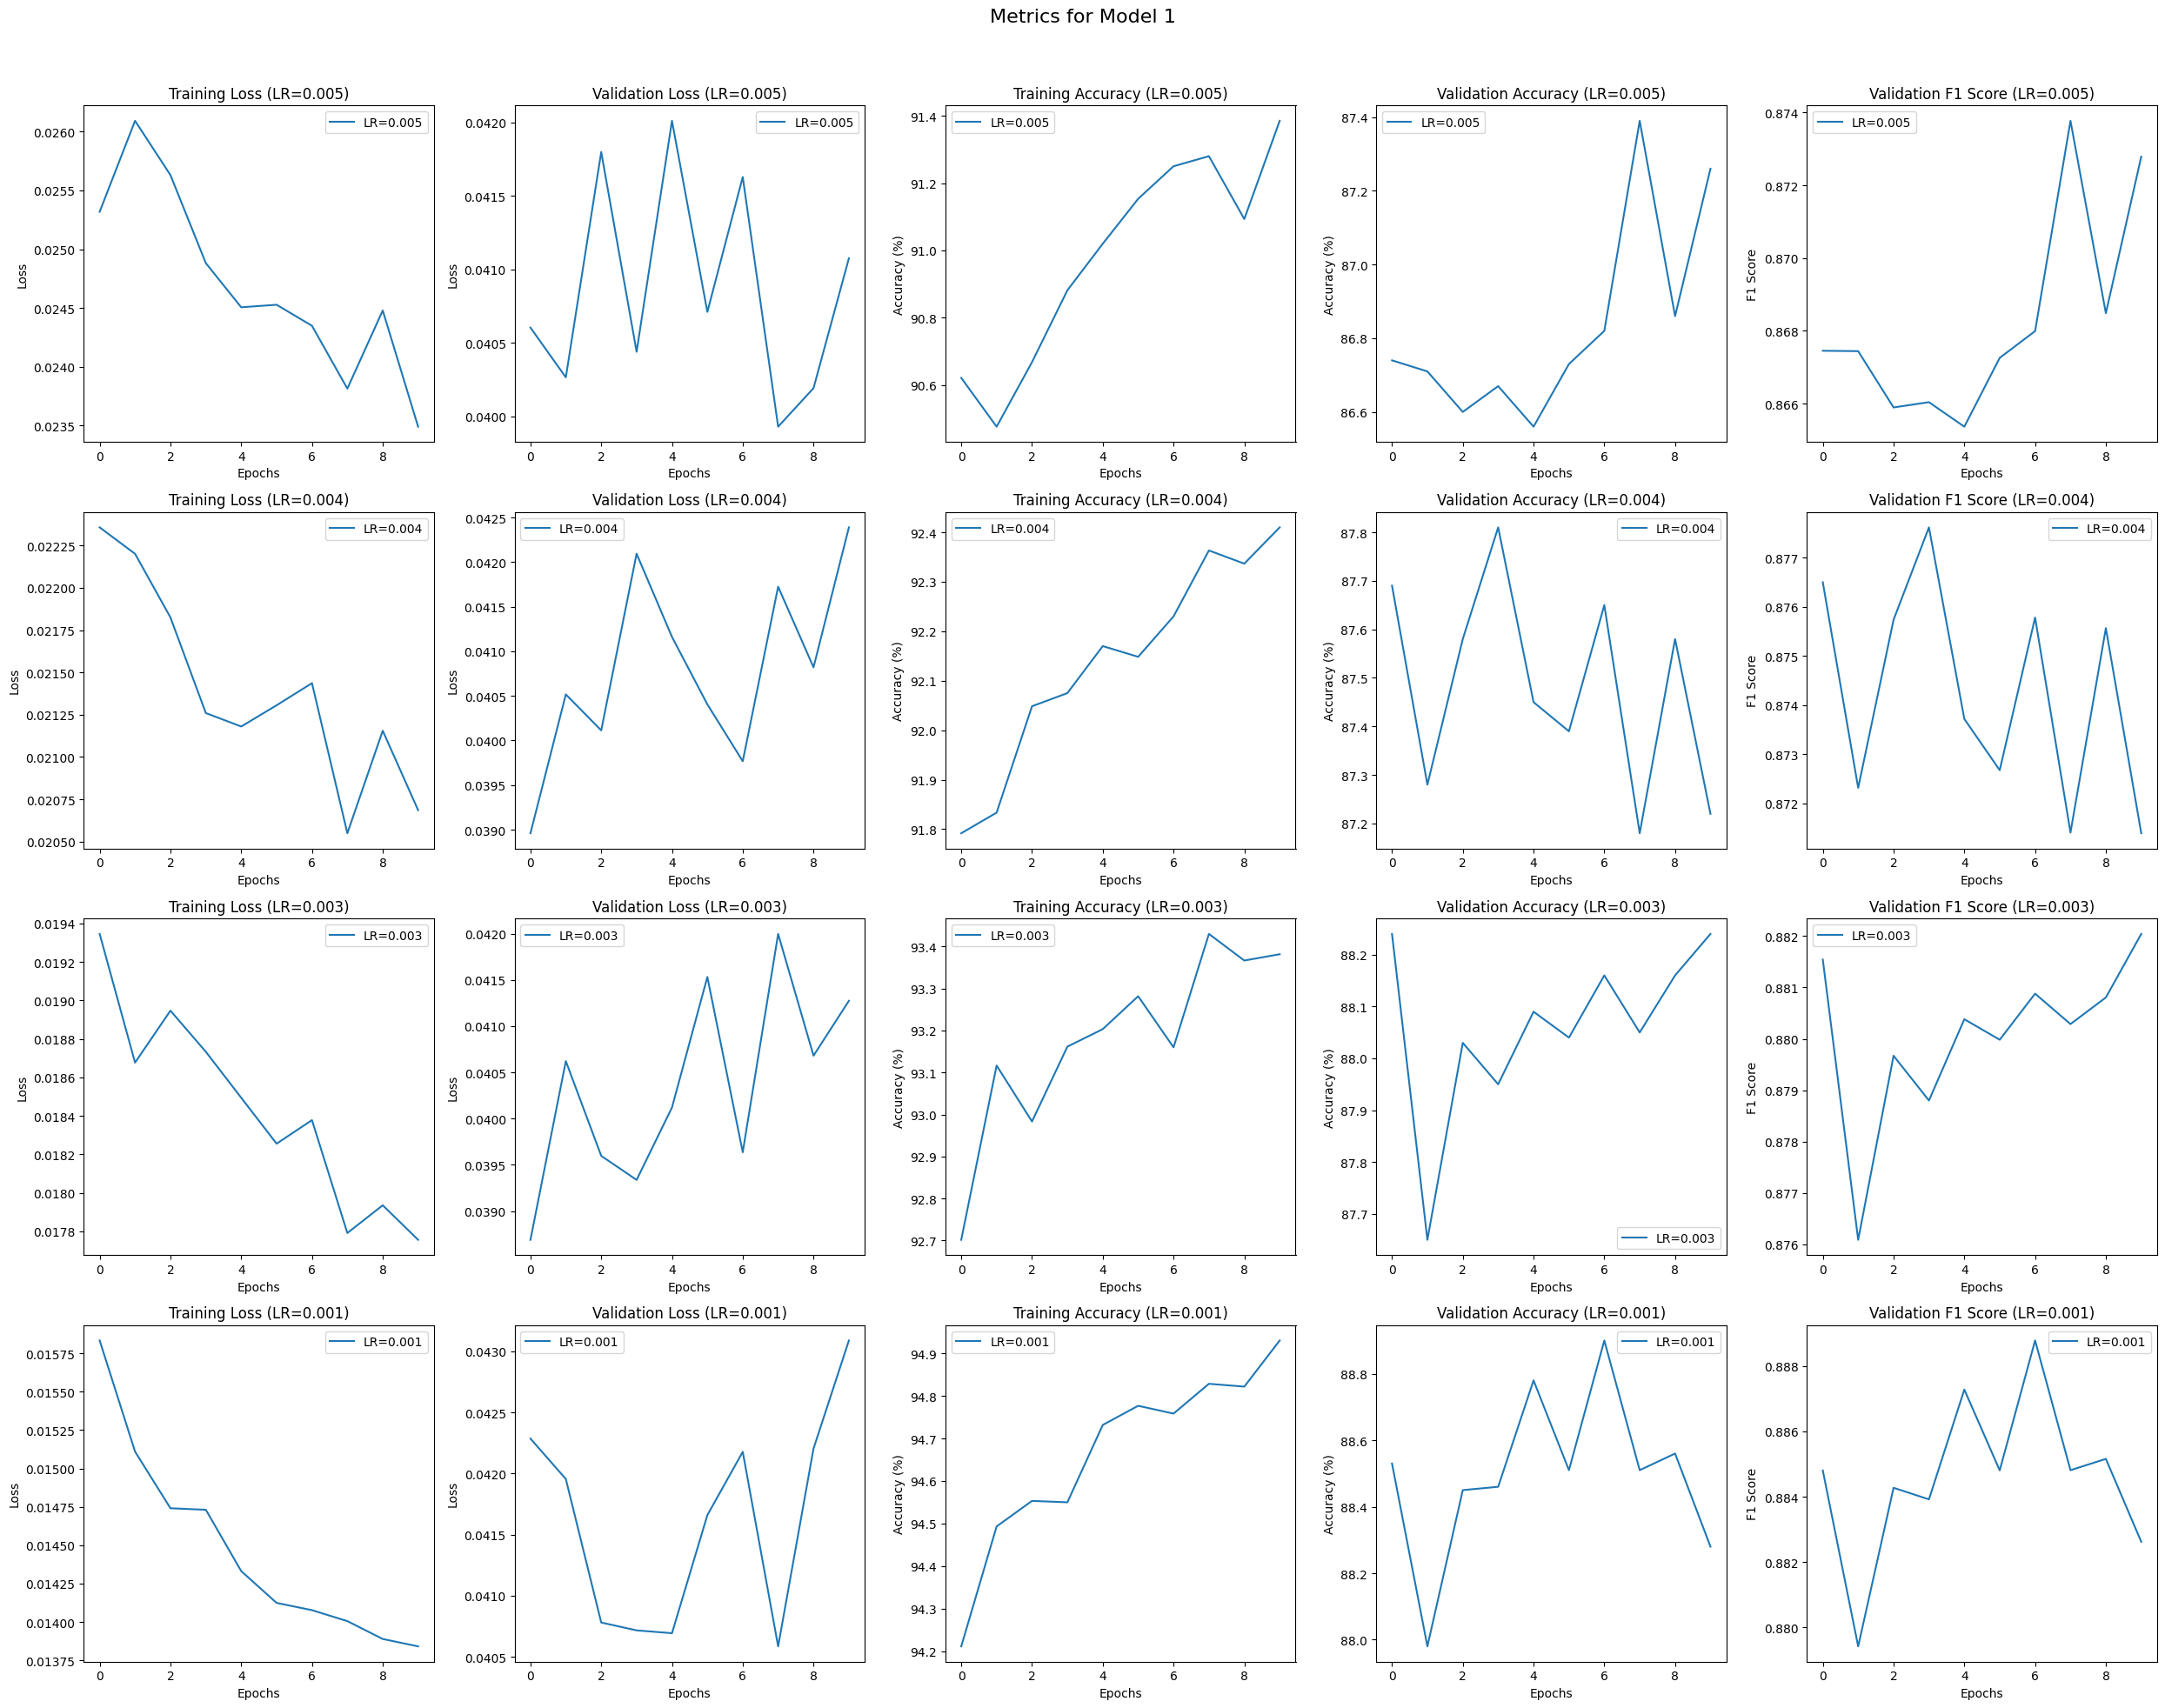

Training Model 2
Training with learning rate: 0.005


 10%|█         | 1/10 [00:06<00:55,  6.19s/it]

Epoch 1/10


 20%|██        | 2/10 [00:13<00:56,  7.02s/it]

Epoch 2/10


 30%|███       | 3/10 [00:20<00:49,  7.03s/it]

Epoch 3/10


 40%|████      | 4/10 [00:26<00:39,  6.63s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:32<00:31,  6.22s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:37<00:23,  5.93s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:42<00:17,  5.71s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:48<00:11,  5.59s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:53<00:05,  5.49s/it]

Epoch 9/10


100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


Epoch 10/10
Training with learning rate: 0.004


 10%|█         | 1/10 [00:05<00:48,  5.44s/it]

Epoch 1/10


 20%|██        | 2/10 [00:10<00:42,  5.27s/it]

Epoch 2/10


 30%|███       | 3/10 [00:15<00:36,  5.26s/it]

Epoch 3/10


 40%|████      | 4/10 [00:20<00:31,  5.19s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:26<00:26,  5.27s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:32<00:21,  5.43s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:38<00:17,  5.72s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:44<00:11,  5.91s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:51<00:06,  6.12s/it]

Epoch 9/10


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Epoch 10/10
Training with learning rate: 0.003


 10%|█         | 1/10 [00:05<00:47,  5.31s/it]

Epoch 1/10


 20%|██        | 2/10 [00:10<00:41,  5.23s/it]

Epoch 2/10


 30%|███       | 3/10 [00:15<00:36,  5.20s/it]

Epoch 3/10


 40%|████      | 4/10 [00:21<00:32,  5.47s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:26<00:27,  5.42s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:32<00:21,  5.40s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:37<00:16,  5.34s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:42<00:10,  5.32s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:47<00:05,  5.29s/it]

Epoch 9/10


100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


Epoch 10/10
Training with learning rate: 0.001


 10%|█         | 1/10 [00:05<00:48,  5.36s/it]

Epoch 1/10


 20%|██        | 2/10 [00:10<00:41,  5.23s/it]

Epoch 2/10


 30%|███       | 3/10 [00:15<00:37,  5.29s/it]

Epoch 3/10


 40%|████      | 4/10 [00:21<00:31,  5.24s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:26<00:26,  5.22s/it]

Epoch 5/10


 60%|██████    | 6/10 [00:31<00:21,  5.25s/it]

Epoch 6/10


 70%|███████   | 7/10 [00:36<00:15,  5.21s/it]

Epoch 7/10


 80%|████████  | 8/10 [00:41<00:10,  5.20s/it]

Epoch 8/10


 90%|█████████ | 9/10 [00:46<00:05,  5.19s/it]

Epoch 9/10


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]

Epoch 10/10


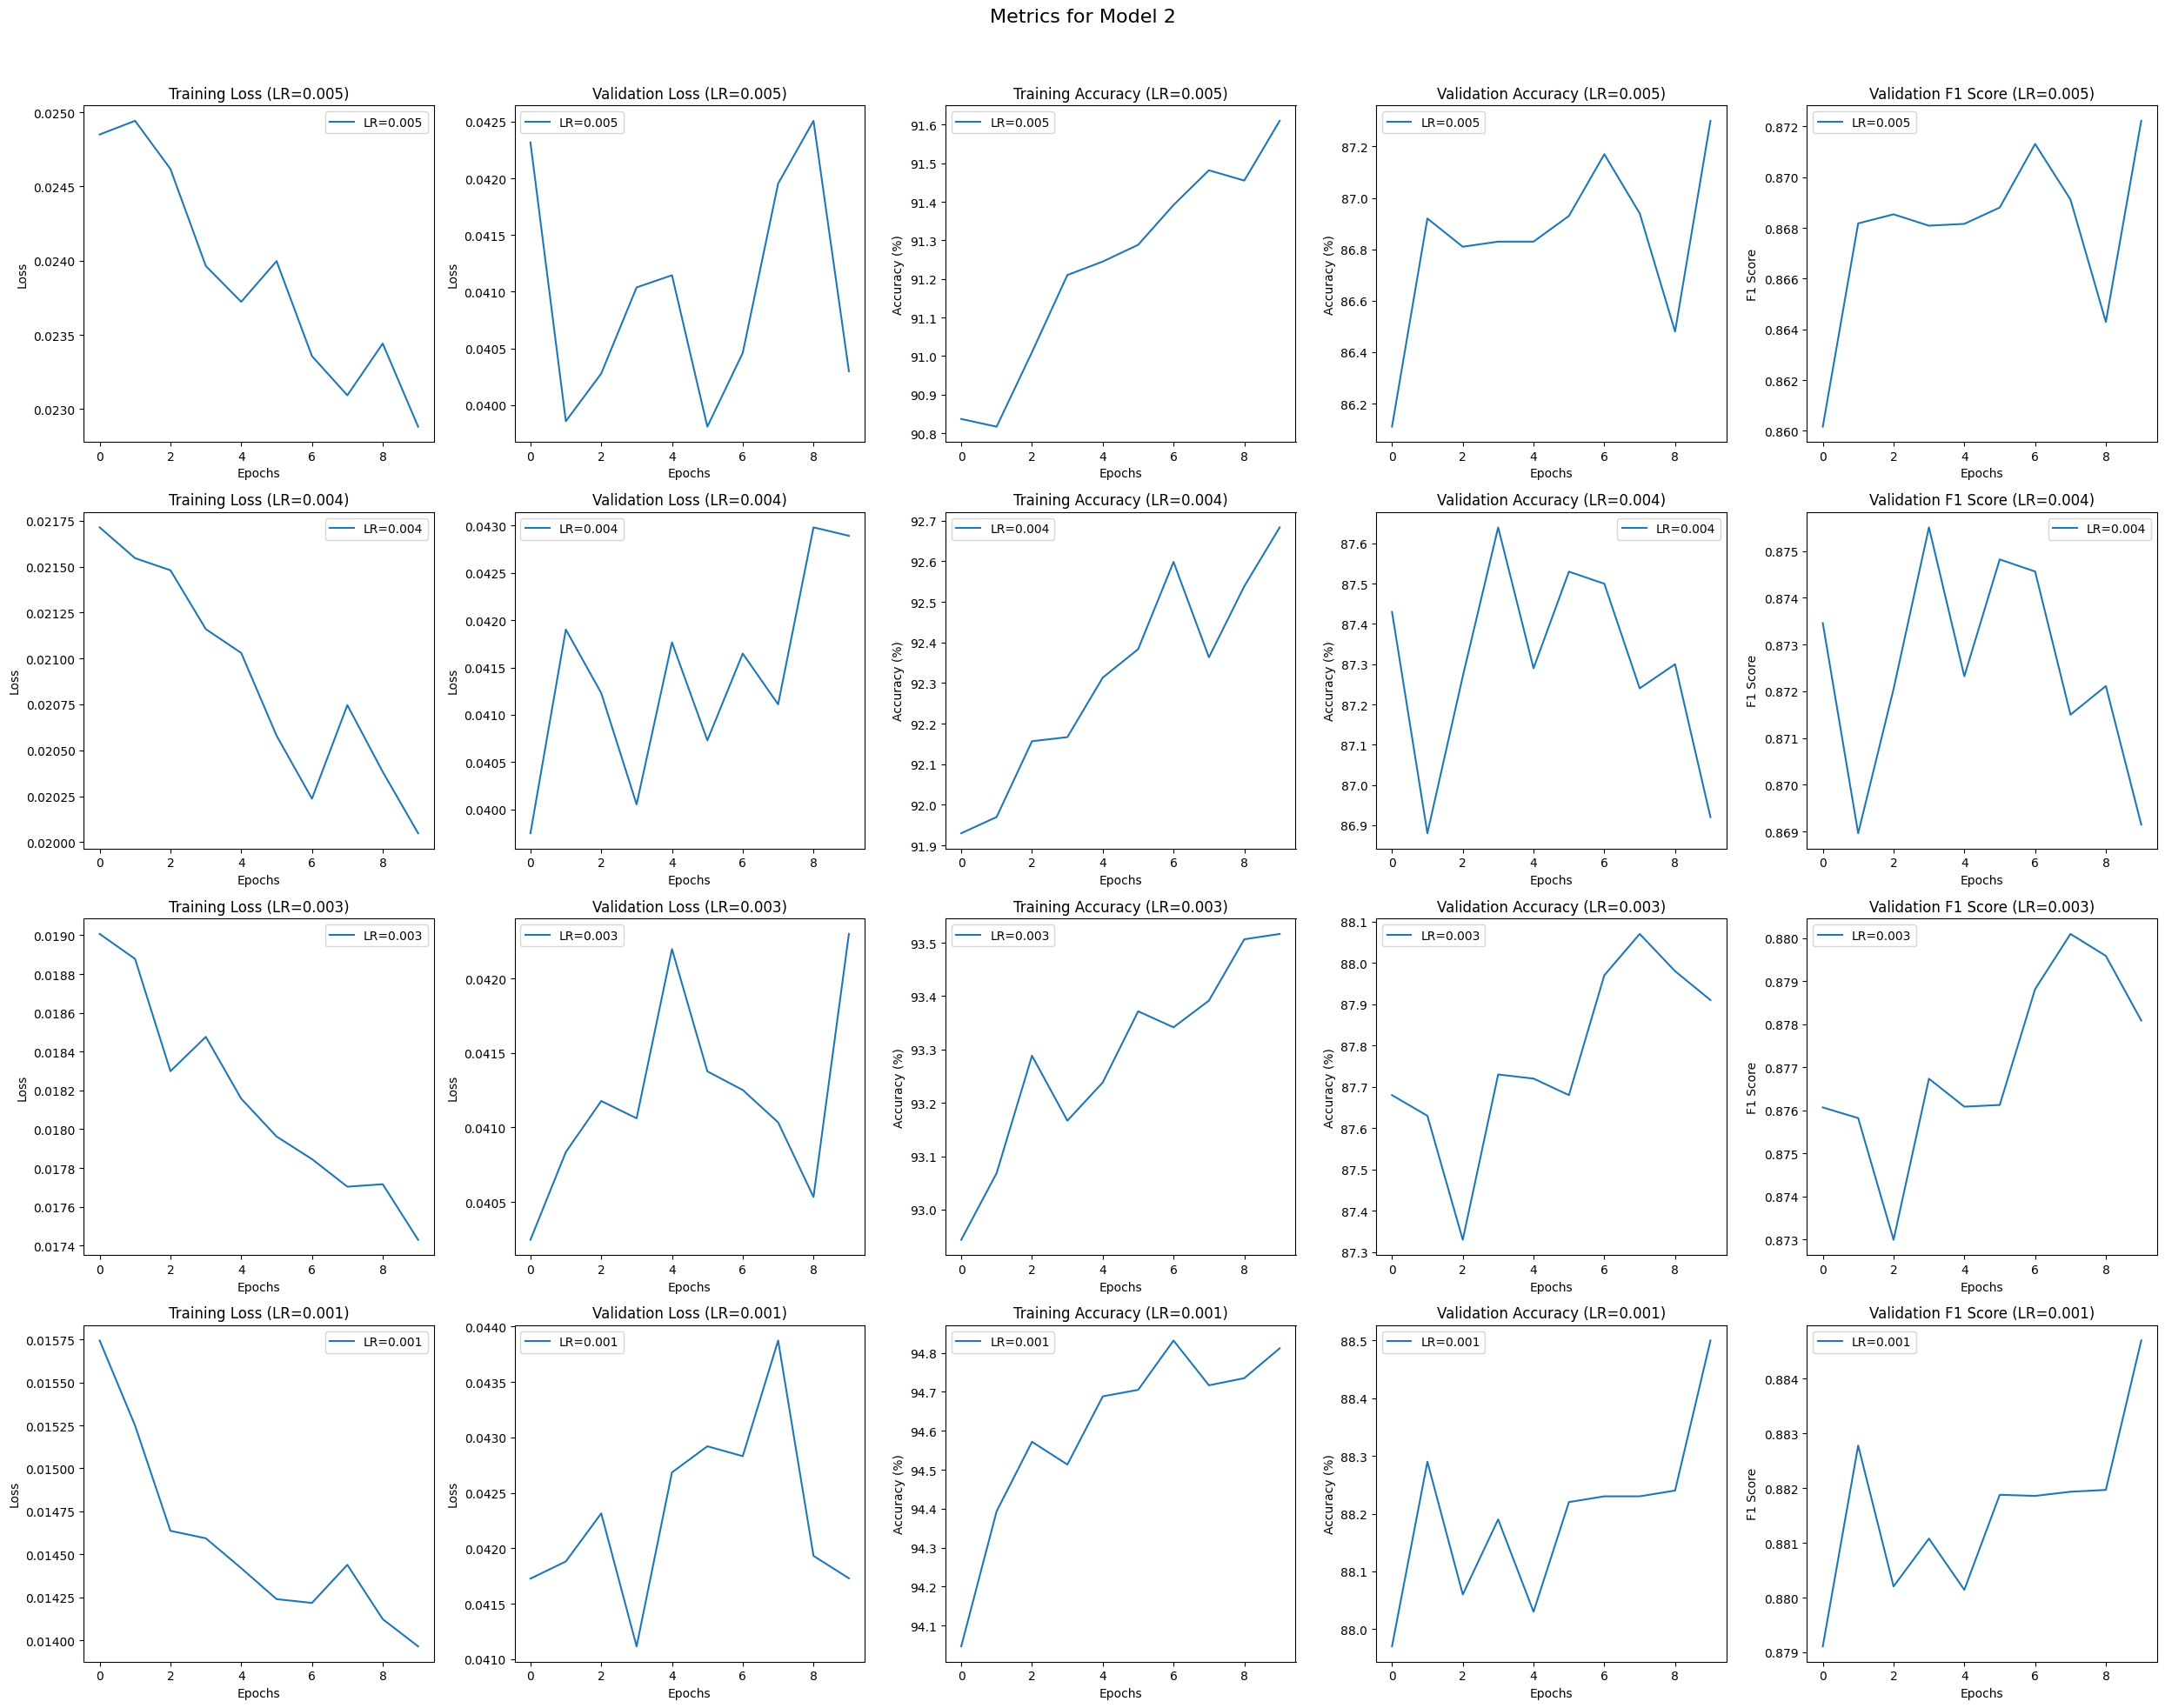

Training Model 3
Training with learning rate: 0.005


 10%|█         | 1/10 [00:24<03:42, 24.70s/it]

Epoch 1/10


 20%|██        | 2/10 [00:51<03:28, 26.06s/it]

Epoch 2/10


 30%|███       | 3/10 [01:15<02:55, 25.14s/it]

Epoch 3/10


 40%|████      | 4/10 [01:40<02:28, 24.83s/it]

Epoch 4/10


 50%|█████     | 5/10 [02:04<02:03, 24.73s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:28<01:37, 24.45s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:52<01:12, 24.20s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:16<00:48, 24.37s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:42<00:24, 24.62s/it]

Epoch 9/10


100%|██████████| 10/10 [04:07<00:00, 24.74s/it]


Epoch 10/10
Training with learning rate: 0.004


 10%|█         | 1/10 [00:25<03:45, 25.03s/it]

Epoch 1/10


 20%|██        | 2/10 [00:51<03:27, 25.90s/it]

Epoch 2/10


 30%|███       | 3/10 [01:17<03:00, 25.80s/it]

Epoch 3/10


 40%|████      | 4/10 [01:42<02:34, 25.71s/it]

Epoch 4/10


 50%|█████     | 5/10 [02:08<02:08, 25.79s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:34<01:42, 25.68s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:59<01:16, 25.43s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:22<00:49, 24.85s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:46<00:24, 24.39s/it]

Epoch 9/10


100%|██████████| 10/10 [04:09<00:00, 24.94s/it]


Epoch 10/10
Training with learning rate: 0.003


 10%|█         | 1/10 [00:23<03:30, 23.42s/it]

Epoch 1/10


 20%|██        | 2/10 [00:46<03:06, 23.27s/it]

Epoch 2/10


 30%|███       | 3/10 [01:09<02:43, 23.31s/it]

Epoch 3/10


 40%|████      | 4/10 [01:32<02:18, 23.14s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:55<01:55, 23.05s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:18<01:32, 23.01s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:42<01:09, 23.16s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:06<00:47, 23.61s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:30<00:23, 23.81s/it]

Epoch 9/10


100%|██████████| 10/10 [03:55<00:00, 23.55s/it]


Epoch 10/10
Training with learning rate: 0.001


 10%|█         | 1/10 [00:24<03:39, 24.36s/it]

Epoch 1/10


 20%|██        | 2/10 [00:48<03:13, 24.21s/it]

Epoch 2/10


 30%|███       | 3/10 [01:12<02:49, 24.15s/it]

Epoch 3/10


 40%|████      | 4/10 [01:42<02:39, 26.53s/it]

Epoch 4/10


 50%|█████     | 5/10 [02:09<02:13, 26.79s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:36<01:46, 26.64s/it]

Epoch 6/10


 70%|███████   | 7/10 [03:02<01:19, 26.46s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:29<00:53, 26.60s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:54<00:26, 26.28s/it]

Epoch 9/10


100%|██████████| 10/10 [04:21<00:00, 26.13s/it]

Epoch 10/10


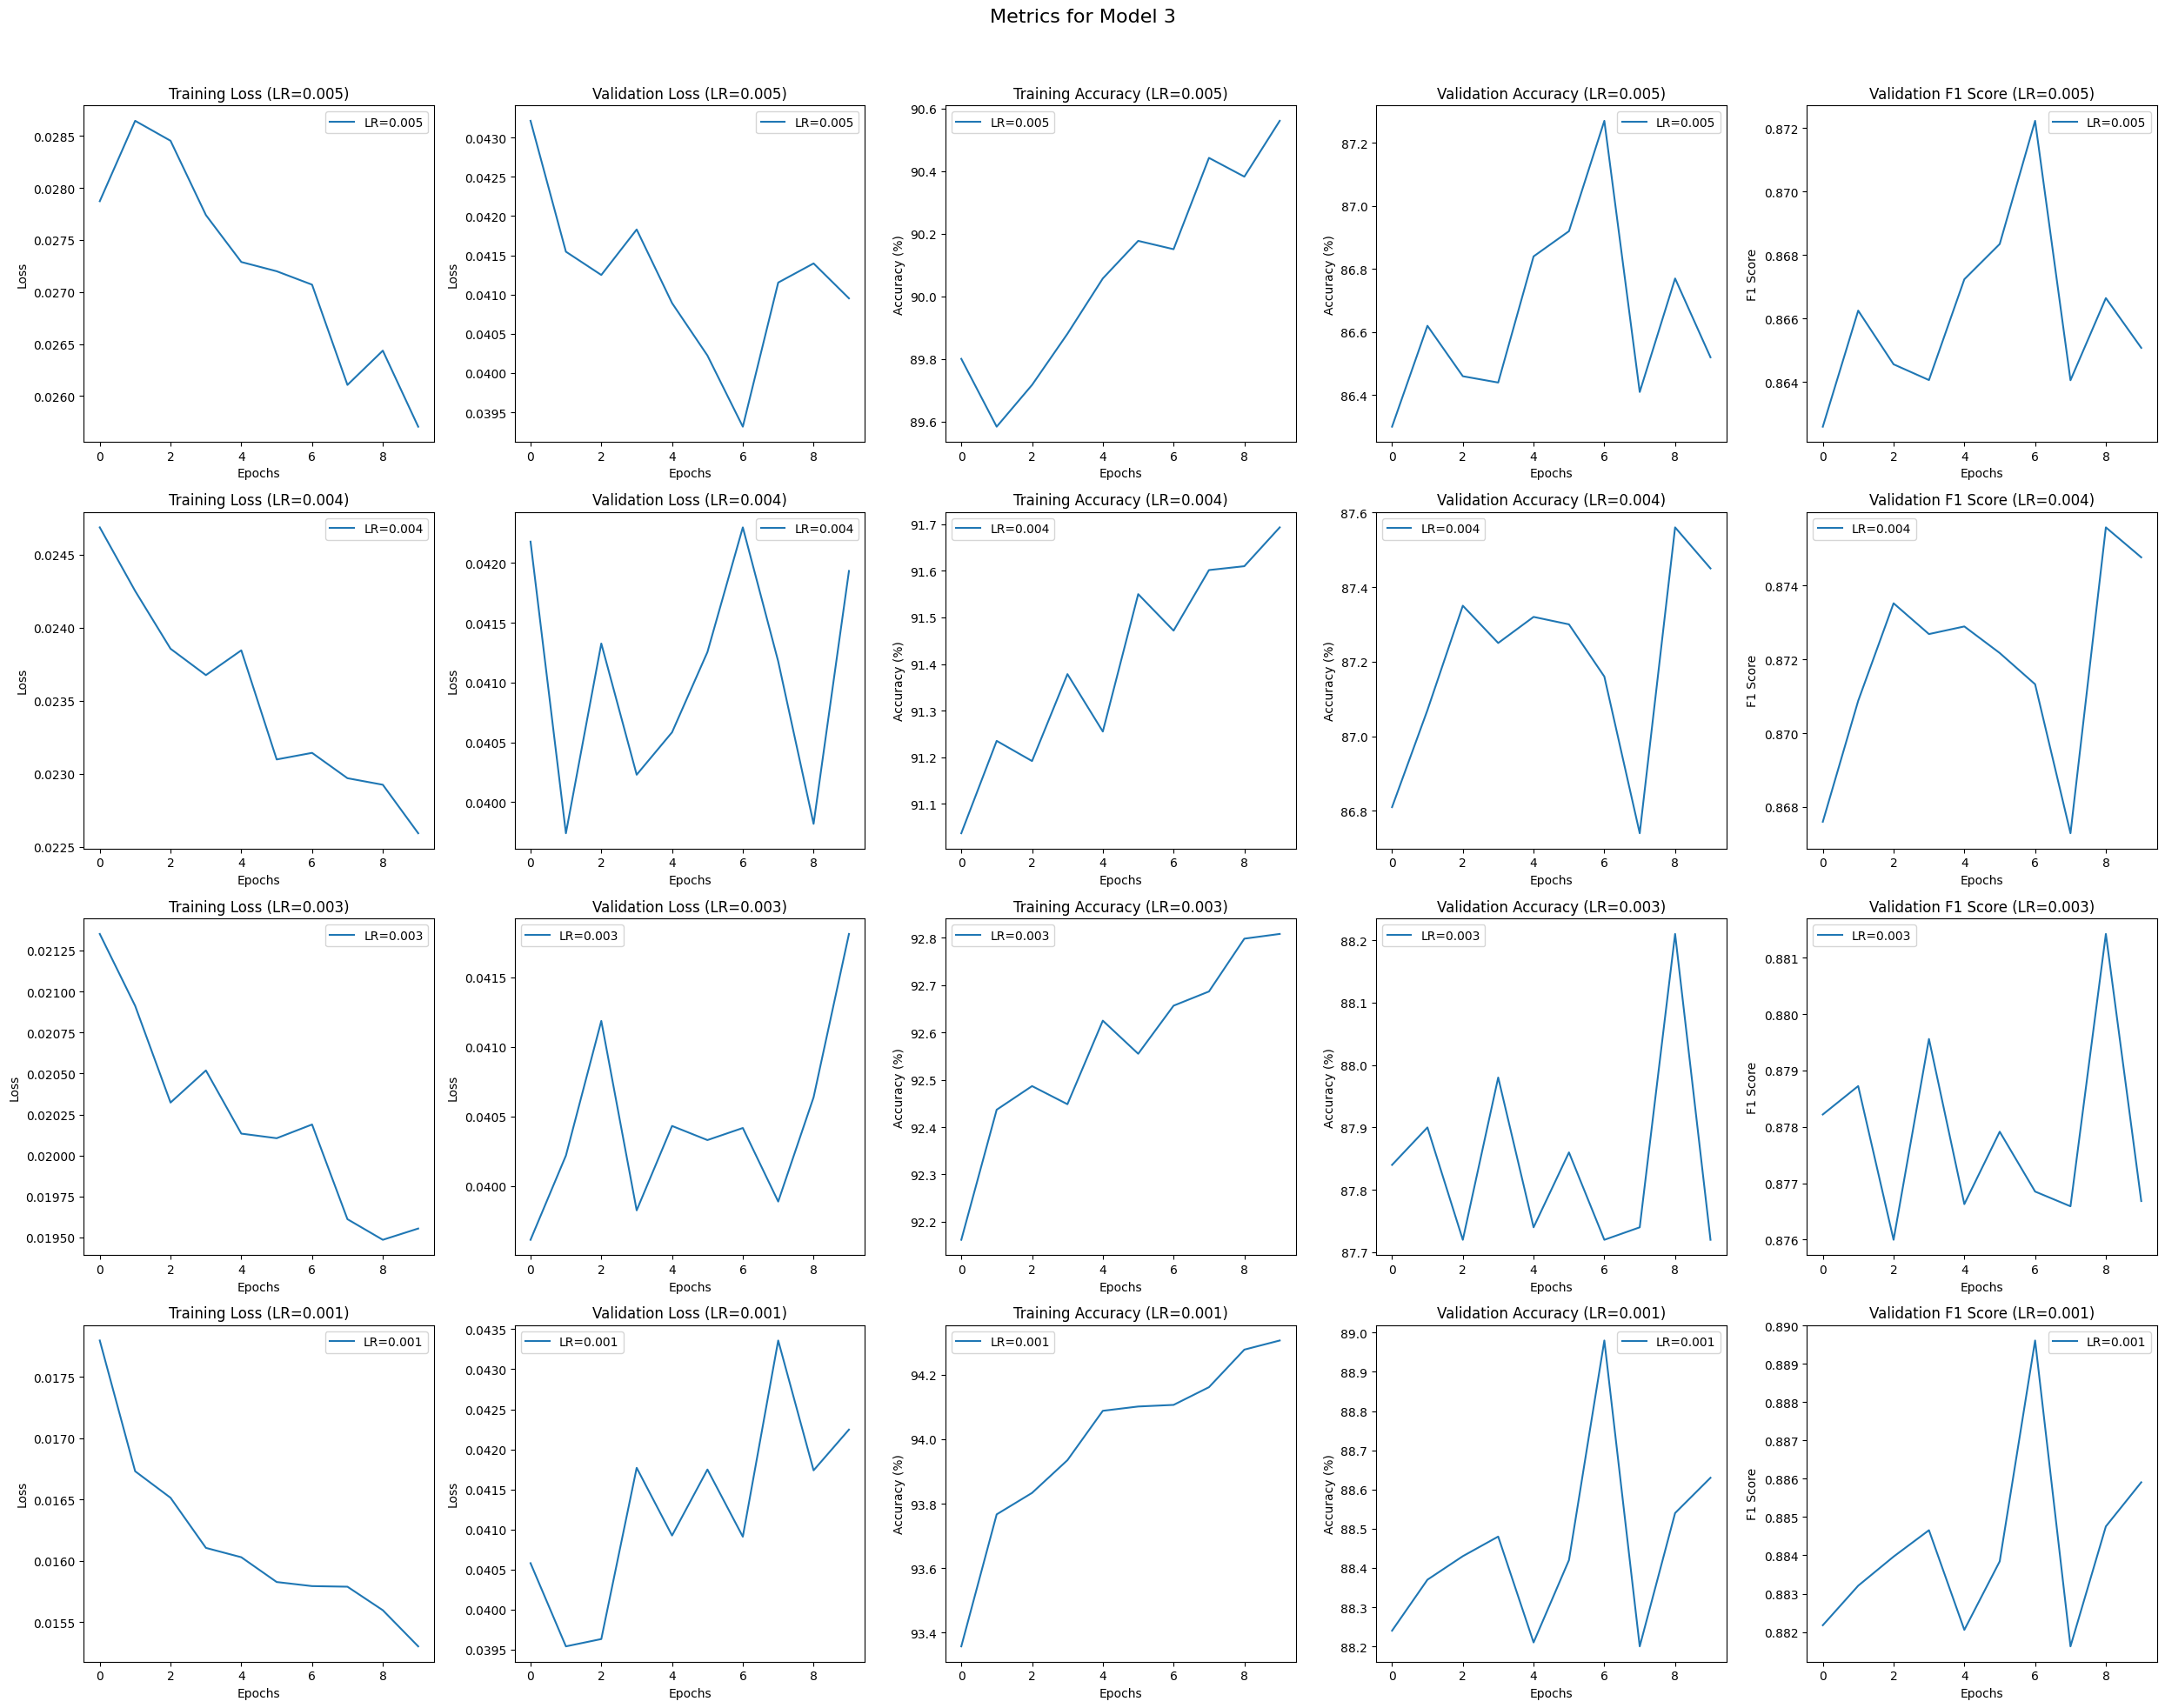

In [38]:
import matplotlib.pyplot as plt


for model_idx, model in enumerate(models):
    print(f"Training Model {model_idx + 1}")
    
    epoch_losses = []
    epoch_accuracies = []
    val_epoch_losses = []
    val_epoch_accuracies = []
    epoch_val_f1s = []

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc, epoch_val_f1 = model.train(
            CrossEntropyLoss(), train_data, train_labels, test_data, test_labels, 10, lr, 256
        )
        
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_train_acc)
        val_epoch_losses.append(epoch_val_loss)
        val_epoch_accuracies.append(epoch_val_acc)
        epoch_val_f1s.append(epoch_val_f1)

    fig, axs = plt.subplots(len(learning_rates), 5, figsize=(25, 20))
    fig.suptitle(f'Metrics for Model {model_idx + 1}', fontsize=16)

    for i, lr in enumerate(learning_rates):
        # Plot training loss
        axs[i, 0].plot(range(len(epoch_losses[i])), epoch_losses[i], label=f'LR={lr}')
        axs[i, 0].set_title(f'Training Loss (LR={lr})')
        axs[i, 0].set_xlabel('Epochs')
        axs[i, 0].set_ylabel('Loss')
        axs[i, 0].legend()

        # Plot validation loss
        axs[i, 1].plot(range(len(val_epoch_losses[i])), val_epoch_losses[i], label=f'LR={lr}')
        axs[i, 1].set_title(f'Validation Loss (LR={lr})')
        axs[i, 1].set_xlabel('Epochs')
        axs[i, 1].set_ylabel('Loss')
        axs[i, 1].legend()

        # Plot training accuracy
        axs[i, 2].plot(range(len(epoch_accuracies[i])), epoch_accuracies[i], label=f'LR={lr}')
        axs[i, 2].set_title(f'Training Accuracy (LR={lr})')
        axs[i, 2].set_xlabel('Epochs')
        axs[i, 2].set_ylabel('Accuracy (%)')
        axs[i, 2].legend()

        # Plot validation accuracy
        axs[i, 3].plot(range(len(val_epoch_accuracies[i])), val_epoch_accuracies[i], label=f'LR={lr}')
        axs[i, 3].set_title(f'Validation Accuracy (LR={lr})')
        axs[i, 3].set_xlabel('Epochs')
        axs[i, 3].set_ylabel('Accuracy (%)')
        axs[i, 3].legend()

        # Plot F1 score
        axs[i, 4].plot(range(len(epoch_val_f1s[i])), epoch_val_f1s[i], label=f'LR={lr}')
        axs[i, 4].set_title(f'Validation F1 Score (LR={lr})')
        axs[i, 4].set_xlabel('Epochs')
        axs[i, 4].set_ylabel('F1 Score')
        axs[i, 4].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()


Confusion Matrix

Training Model 1
Training with learning rate: 0.005


 10%|█         | 1/10 [00:14<02:11, 14.64s/it]

Epoch 1/10


 20%|██        | 2/10 [00:28<01:54, 14.25s/it]

Epoch 2/10


 30%|███       | 3/10 [00:40<01:30, 12.99s/it]

Epoch 3/10


 40%|████      | 4/10 [00:51<01:14, 12.33s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:02<00:59, 11.93s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:13<00:46, 11.65s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:24<00:34, 11.45s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:35<00:22, 11.35s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:46<00:11, 11.25s/it]

Epoch 9/10


100%|██████████| 10/10 [01:58<00:00, 11.82s/it]

Epoch 10/10


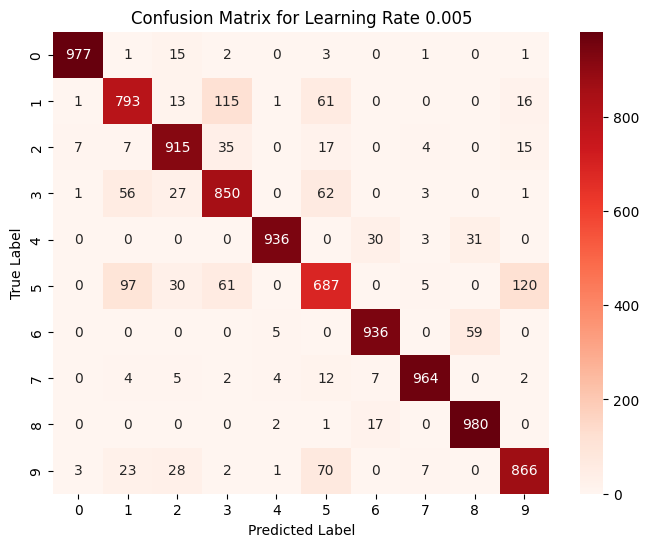

Training with learning rate: 0.004


 10%|█         | 1/10 [00:11<01:41, 11.23s/it]

Epoch 1/10


 20%|██        | 2/10 [00:22<01:29, 11.21s/it]

Epoch 2/10


 30%|███       | 3/10 [00:33<01:19, 11.32s/it]

Epoch 3/10


 40%|████      | 4/10 [00:46<01:10, 11.77s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:57<00:58, 11.69s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:09<00:46, 11.64s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:21<00:34, 11.67s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:33<00:23, 11.75s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:44<00:11, 11.71s/it]

Epoch 9/10


100%|██████████| 10/10 [01:56<00:00, 11.65s/it]

Epoch 10/10


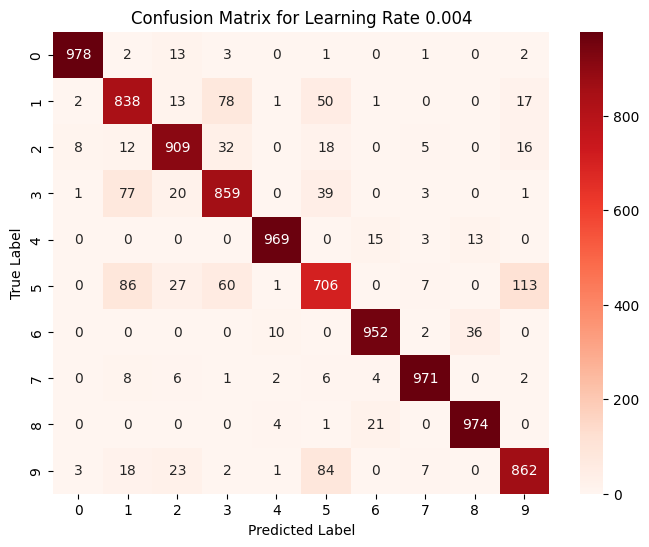

Training with learning rate: 0.003


 10%|█         | 1/10 [00:12<01:48, 12.02s/it]

Epoch 1/10


 20%|██        | 2/10 [00:27<01:50, 13.85s/it]

Epoch 2/10


 30%|███       | 3/10 [00:39<01:32, 13.18s/it]

Epoch 3/10


 40%|████      | 4/10 [00:50<01:14, 12.48s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:02<01:00, 12.10s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:13<00:47, 11.84s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:25<00:35, 11.78s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:38<00:24, 12.06s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:50<00:12, 12.12s/it]

Epoch 9/10


100%|██████████| 10/10 [02:03<00:00, 12.31s/it]

Epoch 10/10


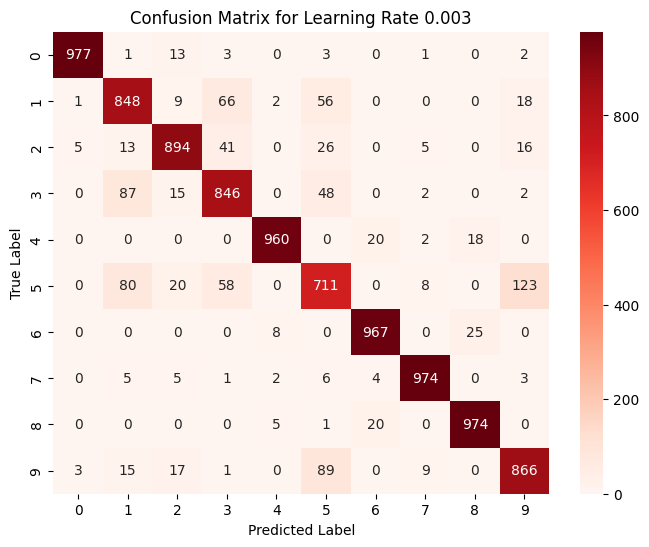

Training with learning rate: 0.001


 10%|█         | 1/10 [00:15<02:20, 15.57s/it]

Epoch 1/10


 20%|██        | 2/10 [00:40<02:50, 21.26s/it]

Epoch 2/10


 30%|███       | 3/10 [01:05<02:40, 22.97s/it]

Epoch 3/10


 40%|████      | 4/10 [01:31<02:24, 24.06s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:58<02:05, 25.19s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:23<01:40, 25.05s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:46<01:13, 24.41s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:09<00:47, 23.95s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:32<00:23, 23.67s/it]

Epoch 9/10


100%|██████████| 10/10 [03:55<00:00, 23.54s/it]

Epoch 10/10


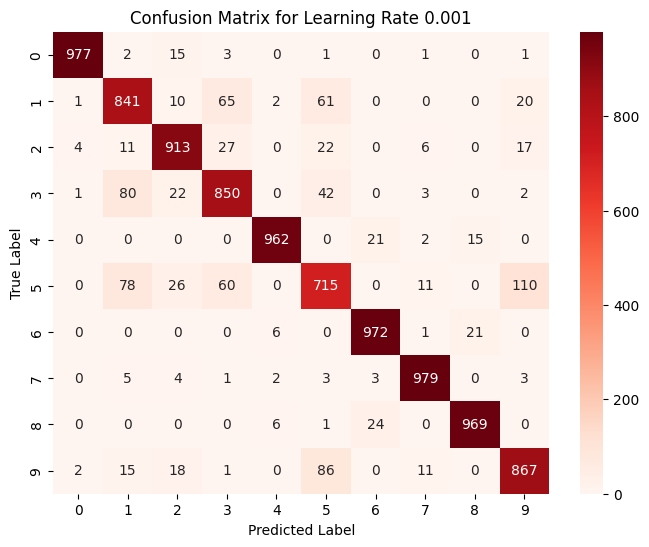

Training Model 2
Training with learning rate: 0.005


 10%|█         | 1/10 [00:11<01:43, 11.48s/it]

Epoch 1/10


 20%|██        | 2/10 [00:23<01:35, 11.91s/it]

Epoch 2/10


 30%|███       | 3/10 [00:34<01:19, 11.42s/it]

Epoch 3/10


 40%|████      | 4/10 [00:44<01:06, 11.01s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:59<01:02, 12.42s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:15<00:53, 13.45s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:28<00:40, 13.40s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:43<00:27, 13.86s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:57<00:13, 13.91s/it]

Epoch 9/10


100%|██████████| 10/10 [02:11<00:00, 13.18s/it]

Epoch 10/10


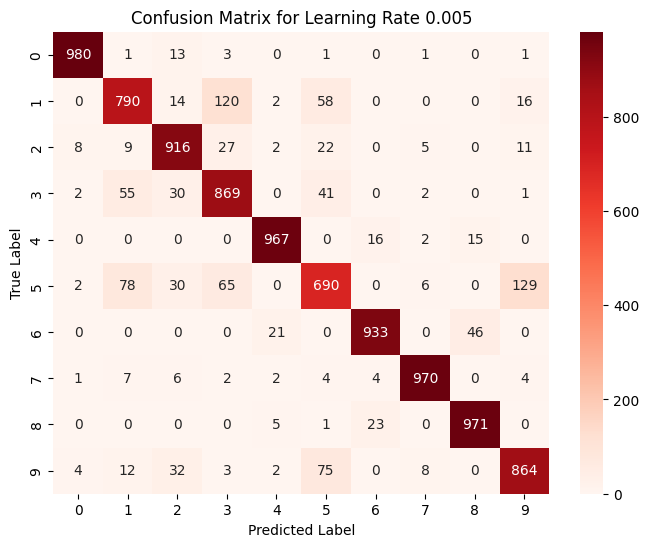

Training with learning rate: 0.004


 10%|█         | 1/10 [00:14<02:10, 14.53s/it]

Epoch 1/10


 20%|██        | 2/10 [00:29<01:58, 14.78s/it]

Epoch 2/10


 30%|███       | 3/10 [00:42<01:37, 13.88s/it]

Epoch 3/10


 40%|████      | 4/10 [00:57<01:27, 14.59s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:12<01:13, 14.71s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:26<00:57, 14.31s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:42<00:44, 14.83s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:56<00:29, 14.60s/it]

Epoch 8/10


 90%|█████████ | 9/10 [02:11<00:14, 14.62s/it]

Epoch 9/10


100%|██████████| 10/10 [02:25<00:00, 14.53s/it]

Epoch 10/10


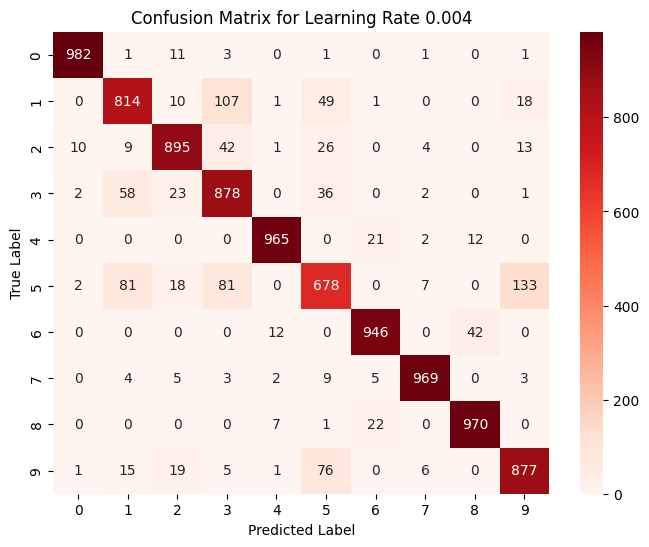

Training with learning rate: 0.003


 10%|█         | 1/10 [00:11<01:41, 11.23s/it]

Epoch 1/10


 20%|██        | 2/10 [00:22<01:30, 11.30s/it]

Epoch 2/10


 30%|███       | 3/10 [00:36<01:26, 12.34s/it]

Epoch 3/10


 40%|████      | 4/10 [00:47<01:10, 11.80s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:57<00:56, 11.31s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:07<00:43, 10.97s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:18<00:32, 10.87s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:28<00:21, 10.74s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:39<00:10, 10.72s/it]

Epoch 9/10


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]

Epoch 10/10


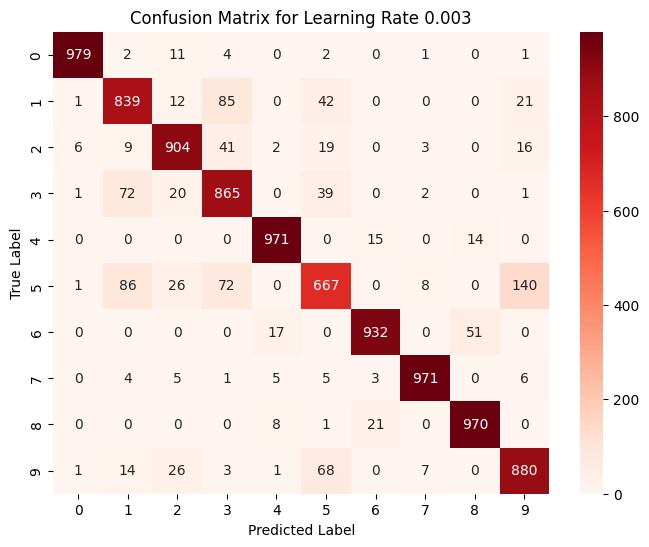

Training with learning rate: 0.001


 10%|█         | 1/10 [00:10<01:37, 10.83s/it]

Epoch 1/10


 20%|██        | 2/10 [00:22<01:28, 11.03s/it]

Epoch 2/10


 30%|███       | 3/10 [00:32<01:14, 10.71s/it]

Epoch 3/10


 40%|████      | 4/10 [00:43<01:04, 10.79s/it]

Epoch 4/10


 50%|█████     | 5/10 [00:53<00:53, 10.65s/it]

Epoch 5/10


 60%|██████    | 6/10 [01:04<00:42, 10.72s/it]

Epoch 6/10


 70%|███████   | 7/10 [01:15<00:32, 10.78s/it]

Epoch 7/10


 80%|████████  | 8/10 [01:25<00:21, 10.65s/it]

Epoch 8/10


 90%|█████████ | 9/10 [01:36<00:10, 10.72s/it]

Epoch 9/10


100%|██████████| 10/10 [01:47<00:00, 10.72s/it]

Epoch 10/10


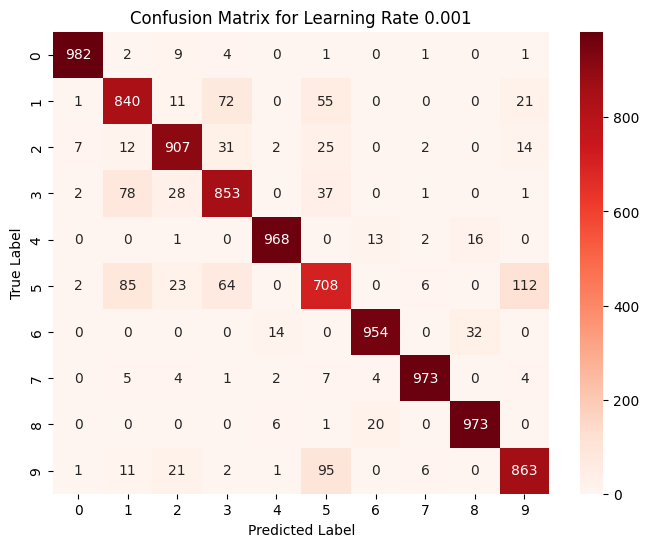

Training Model 3
Training with learning rate: 0.005


 10%|█         | 1/10 [00:39<05:51, 39.02s/it]

Epoch 1/10


 20%|██        | 2/10 [01:18<05:14, 39.35s/it]

Epoch 2/10


 30%|███       | 3/10 [01:58<04:37, 39.58s/it]

Epoch 3/10


 40%|████      | 4/10 [02:42<04:07, 41.20s/it]

Epoch 4/10


 50%|█████     | 5/10 [03:26<03:31, 42.29s/it]

Epoch 5/10


 60%|██████    | 6/10 [04:08<02:49, 42.34s/it]

Epoch 6/10


 70%|███████   | 7/10 [04:50<02:05, 41.98s/it]

Epoch 7/10


 80%|████████  | 8/10 [05:32<01:24, 42.01s/it]

Epoch 8/10


 90%|█████████ | 9/10 [06:14<00:42, 42.01s/it]

Epoch 9/10


100%|██████████| 10/10 [06:57<00:00, 41.70s/it]

Epoch 10/10


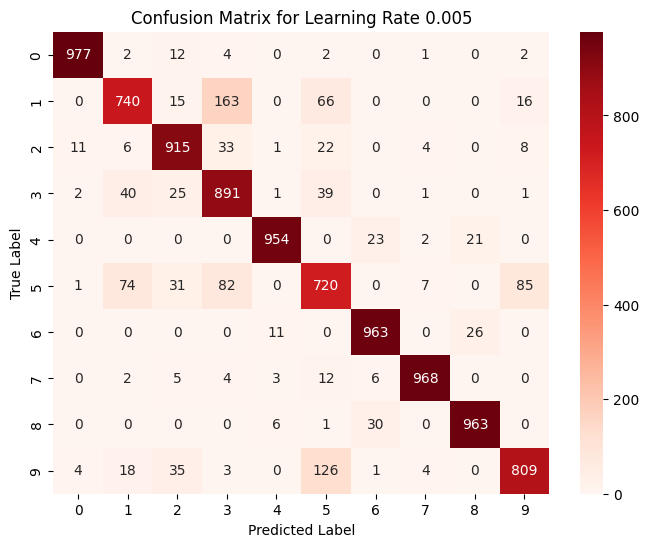

Training with learning rate: 0.004


 10%|█         | 1/10 [00:44<06:39, 44.34s/it]

Epoch 1/10


 20%|██        | 2/10 [01:26<05:42, 42.79s/it]

Epoch 2/10


 30%|███       | 3/10 [02:09<05:00, 42.91s/it]

Epoch 3/10


 40%|████      | 4/10 [02:52<04:17, 42.97s/it]

Epoch 4/10


 50%|█████     | 5/10 [03:47<03:57, 47.46s/it]

Epoch 5/10


 60%|██████    | 6/10 [04:33<03:08, 47.07s/it]

Epoch 6/10


 70%|███████   | 7/10 [05:14<02:14, 44.97s/it]

Epoch 7/10


 80%|████████  | 8/10 [05:54<01:26, 43.44s/it]

Epoch 8/10


 90%|█████████ | 9/10 [06:34<00:42, 42.45s/it]

Epoch 9/10


100%|██████████| 10/10 [07:15<00:00, 43.56s/it]

Epoch 10/10


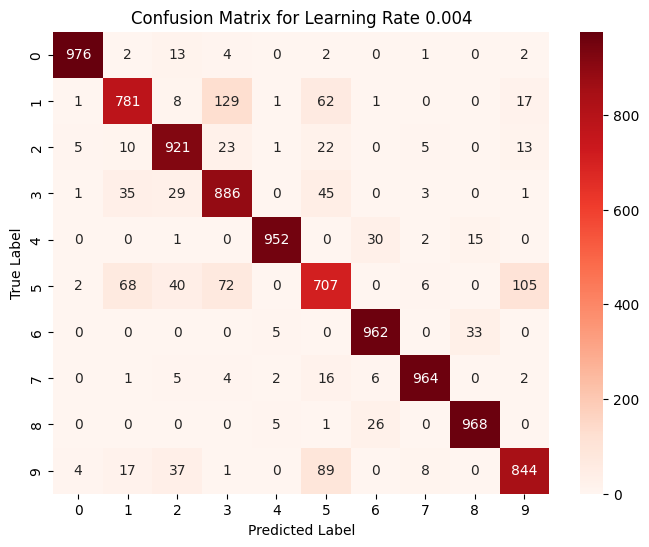

Training with learning rate: 0.003


 10%|█         | 1/10 [00:44<06:44, 44.96s/it]

Epoch 1/10


 20%|██        | 2/10 [01:25<05:40, 42.57s/it]

Epoch 2/10


 30%|███       | 3/10 [02:09<05:00, 42.99s/it]

Epoch 3/10


 40%|████      | 4/10 [02:49<04:11, 41.92s/it]

Epoch 4/10


 50%|█████     | 5/10 [03:29<03:26, 41.23s/it]

Epoch 5/10


 60%|██████    | 6/10 [04:10<02:44, 41.13s/it]

Epoch 6/10


 70%|███████   | 7/10 [04:50<02:02, 40.87s/it]

Epoch 7/10


 80%|████████  | 8/10 [05:28<01:19, 39.83s/it]

Epoch 8/10


 90%|█████████ | 9/10 [06:07<00:39, 39.65s/it]

Epoch 9/10


100%|██████████| 10/10 [06:47<00:00, 40.78s/it]


Epoch 10/10


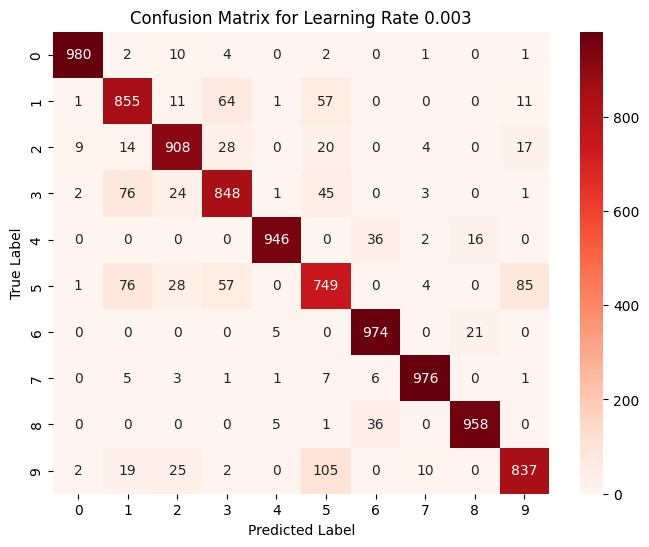

Training with learning rate: 0.001


 10%|█         | 1/10 [00:39<05:58, 39.88s/it]

Epoch 1/10


 20%|██        | 2/10 [01:20<05:20, 40.06s/it]

Epoch 2/10


 30%|███       | 3/10 [01:59<04:37, 39.60s/it]

Epoch 3/10


 40%|████      | 4/10 [02:38<03:56, 39.38s/it]

Epoch 4/10


 50%|█████     | 5/10 [03:16<03:15, 39.09s/it]

Epoch 5/10


 60%|██████    | 6/10 [03:54<02:34, 38.67s/it]

Epoch 6/10


 70%|███████   | 7/10 [04:32<01:55, 38.53s/it]

Epoch 7/10


 80%|████████  | 8/10 [05:14<01:19, 39.52s/it]

Epoch 8/10


 90%|█████████ | 9/10 [05:54<00:39, 39.66s/it]

Epoch 9/10


100%|██████████| 10/10 [06:33<00:00, 39.38s/it]

Epoch 10/10


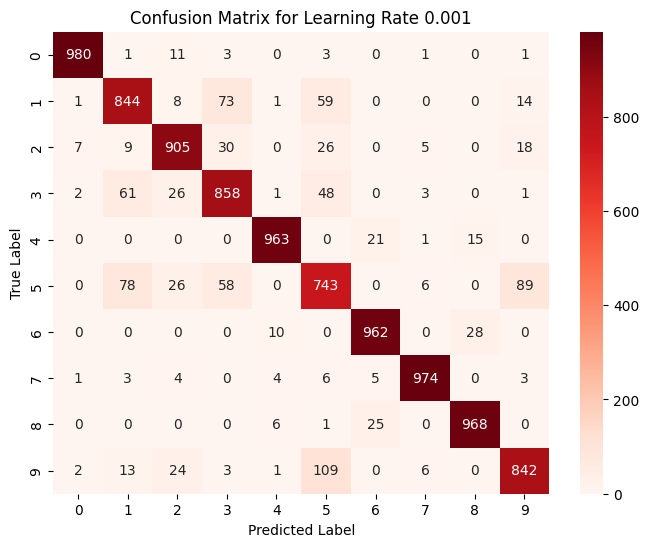

In [39]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, learning_rate):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(f'Confusion Matrix for Learning Rate {learning_rate}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


for i, model in enumerate(models):
    print(f"Training Model {i + 1}")
    for j in range(len(learning_rates)):
        print(f"Training with learning rate: {learning_rates[j]}")
        epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc, epoch_val_f1 = model.train(CrossEntropyLoss(), train_data, train_labels,  test_data, test_labels, 10,learning_rates[j], 256)
        

        # Get predictions for confusion matrix
        y_val_pred = model.predict(test_data)
        y_val_true = np.argmax(test_labels, axis=1)  # Convert one-hot encoded labels to class indices
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)  # Convert predicted probabilities to class indices

        # Plot confusion matrix for the current learning rate
        plot_confusion_matrix(y_val_true, y_val_pred_labels, learning_rates[j])

pickle

In [46]:
import pickle

print(best_model_idx)
print(learning_rates[best_lr])

# Save only the weights to a pickle file
with open('model_1905078.pkl', 'wb') as file:
    pickle.dump(best_model.get_weights(), file)
    
    
print(best_model.get_weights())    



1
0.001
{'layer_0_weights': array([[-1.20428106e-01, -6.45789103e-01,  6.25311898e-02, ...,
         9.49709859e-02,  7.08612968e-01,  6.99385738e-02],
       [-3.22341704e-01,  7.44592352e-01,  1.43165260e-01, ...,
         2.17198294e-01,  3.54069329e-01,  1.45292950e-01],
       [ 4.00346736e-01,  1.47098000e-01,  1.19353639e+00, ...,
         6.09209351e-01,  1.05502885e+00,  3.95433233e-01],
       ...,
       [ 4.16339177e-01,  4.70920132e-01, -9.70266258e-01, ...,
        -7.49831448e-01,  1.66278366e+00,  5.76441999e-01],
       [ 1.19337145e+00,  1.68960708e-03,  5.65171468e-02, ...,
         1.31709878e+00,  1.58231400e+00,  2.77459113e-01],
       [ 1.10049851e+00,  5.83655214e-01,  1.88547453e+00, ...,
         4.99958150e-01,  1.34659025e+00,  8.32791526e-01]]), 'layer_0_biases': array([[ 0.01887697, -0.04822332,  0.05538805,  0.01869594,  0.00380019,
        -0.01018754, -0.00705576,  0.06026855,  0.05396279, -0.12441641,
        -0.04189613, -0.03565273, -0.04195546,  0.

testing model_1905078.pkl

In [48]:
with open('model_1905078.pkl', 'rb') as file:
    loaded_weights = pickle.load(file)
    

layers = best_model.layers
fnn_model = FNN(layers)  

    
def set_weights(self, weights):
    for i, layer in enumerate(self.layers):
        if f'layer_{i}_weights' in weights and f'layer_{i}_biases' in weights:
            layer.weights = weights[f'layer_{i}_weights']
            layer.biases = weights[f'layer_{i}_biases']

set_weights(fnn_model, loaded_weights)
calculate_metrics(fnn_model, test_data, test_labels)




Test Accuracy: 90.45%
Precision: 0.9976275207591934
Recall: 0.998812351543943
F1 Score: 0.9982195845697329
Specificity: 0.9979570990806946
